In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# import statsmodels.api as sm
import glob

import scipy as sc
from pandas import read_csv

data = pd.read_csv("ElectricCarData_Clean.csv")

In [111]:
data = data.drop(['PlugType'], axis = 1)

data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(str).str.replace('-','0')
data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(float)

data.columns = data.columns.str.replace('AccelSec', 'Acceleration 0-100 (s)')
data.columns = data.columns.str.replace('TopSpeed_KmH', 'TopSpeed (km/h)')
data.columns = data.columns.str.replace('Range_Km', 'Range (km)')
data.columns = data.columns.str.replace('Efficiency_WhKm', 'Efficiency (Wh/km)')
data.columns = data.columns.str.replace('FastCharge_KmH', 'FastCharge (km/h)')

In [112]:
data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250.0,Yes,RWD,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Hatchback,B,4,32997


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   103 non-null    object 
 1   Model                   103 non-null    object 
 2   Acceleration 0-100 (s)  103 non-null    float64
 3   TopSpeed (km/h)         103 non-null    int64  
 4   Range (km)              103 non-null    int64  
 5   Efficiency (Wh/km)      103 non-null    int64  
 6   FastCharge (km/h)       103 non-null    float64
 7   RapidCharge             103 non-null    object 
 8   PowerTrain              103 non-null    object 
 9   BodyStyle               103 non-null    object 
 10  Segment                 103 non-null    object 
 11  Seats                   103 non-null    int64  
 12  PriceEuro               103 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 10.6+ KB


In [114]:
data.isnull().sum()

Brand                     0
Model                     0
Acceleration 0-100 (s)    0
TopSpeed (km/h)           0
Range (km)                0
Efficiency (Wh/km)        0
FastCharge (km/h)         0
RapidCharge               0
PowerTrain                0
BodyStyle                 0
Segment                   0
Seats                     0
PriceEuro                 0
dtype: int64

In [115]:
data.describe()

,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,434.563107,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,219.660061,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,0.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,260.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,440.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,555.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,940.000000,7.000000,215000.000000


In [107]:
# for column in data.columns:
#     print(column)
#     print(data[column].head())
#     data[column] = data[column].astype(str).str.replace(',','.')
#     if(column != 'Country' and column != 'Region'):
#         data[column] = data[column].astype(float)

<AxesSubplot:>

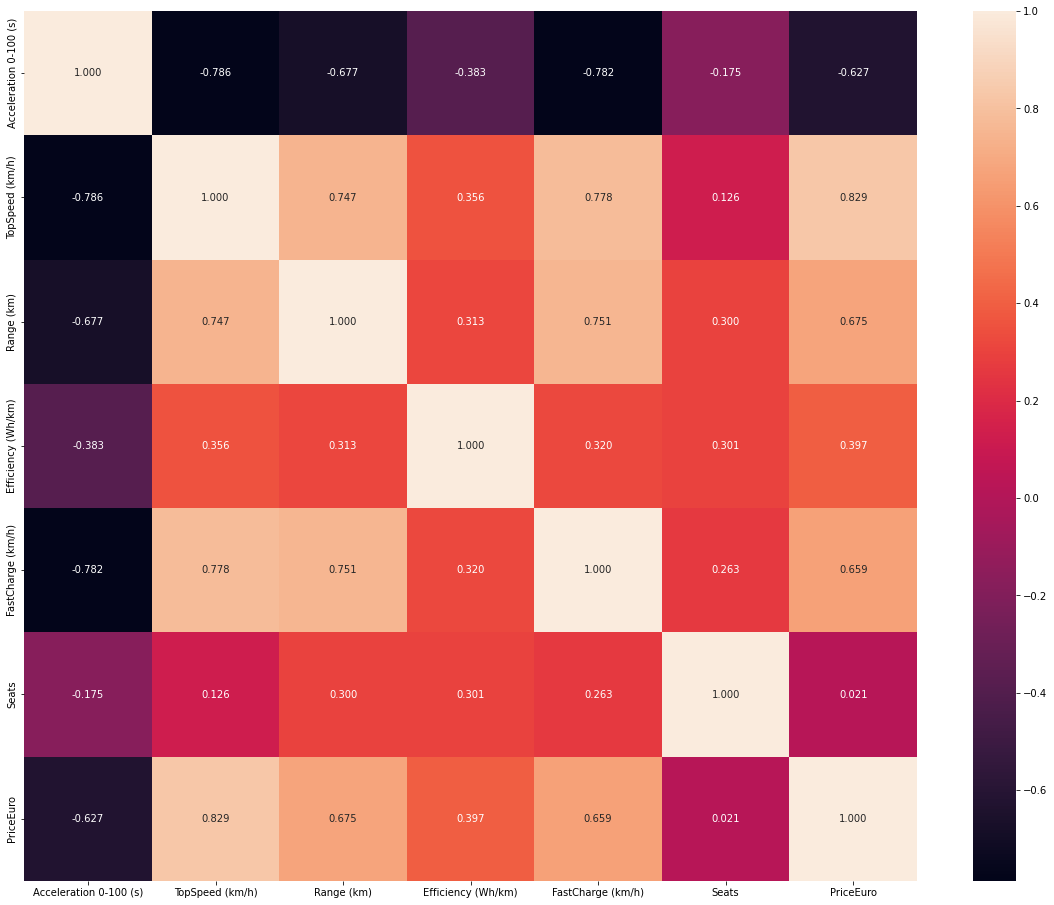

In [109]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(data.corr(), ax = ax, annot = True, fmt = ".3f")

In [76]:
data['Segment'].unique()

array(['D', 'C', 'B', 'F', 'A', 'E', 'N', 'S'], dtype=object)

In [71]:
# A	mini
# B	small
# C	medium
# D	large
# E	executive
# F	luxury

# J	SUV
# M	MPV

# N	VAN
# S	sports

In [72]:
# A watt hour per kilometer (Wh/km) measures how many watt hours of electricity a car consumes to travel distance of 1 kilometer.
# 1 Wh/km = 1 000 km/kWh

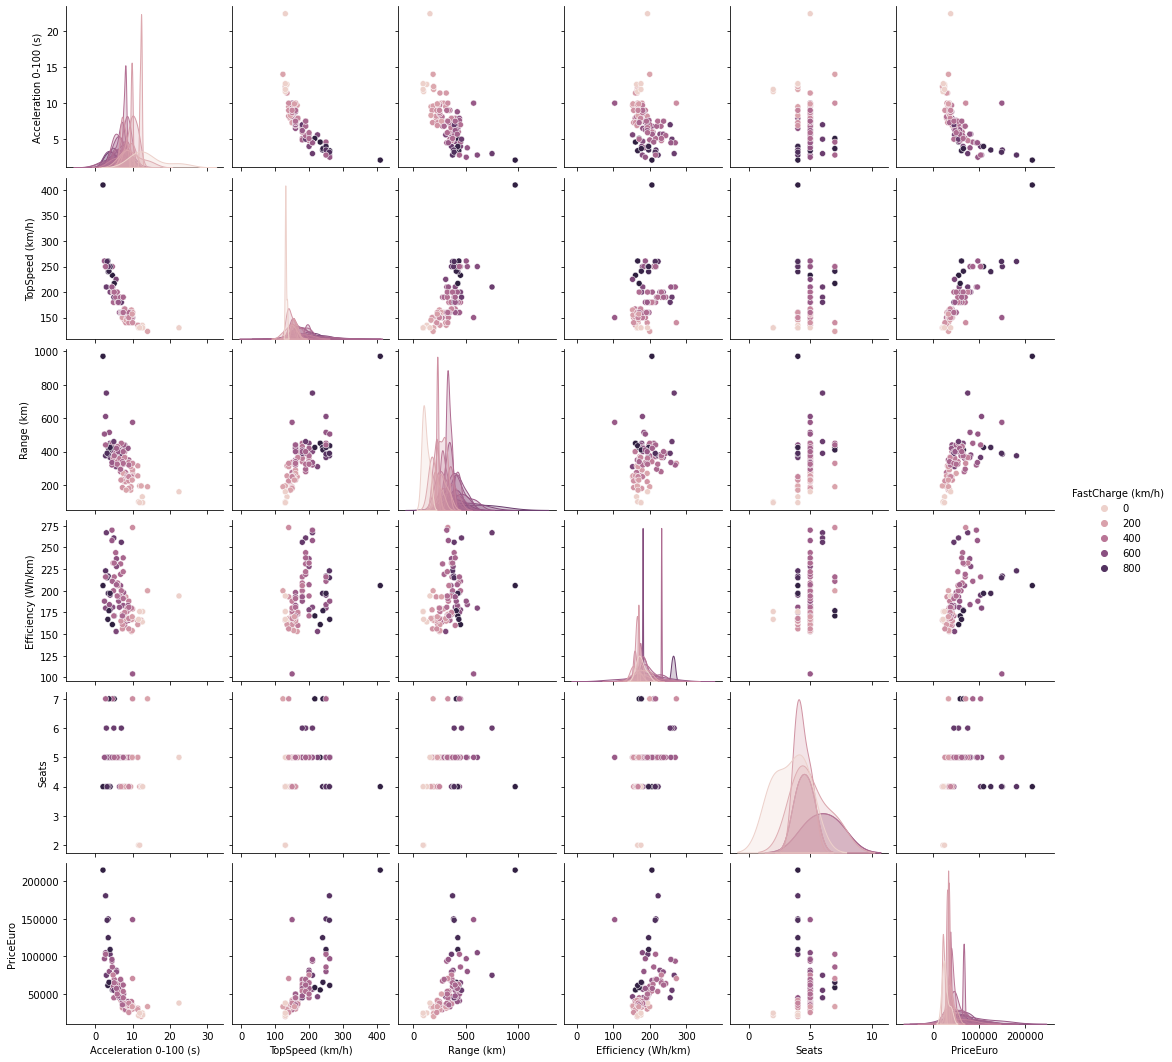

In [119]:
sns.pairplot(data,hue='FastCharge (km/h)')